In [1]:
import torch
print(torch.version.cuda)


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)
print(f"Using device: {device}")

11.8
MPS not available because the current PyTorch install was not built with MPS enabled.
Using device: cuda


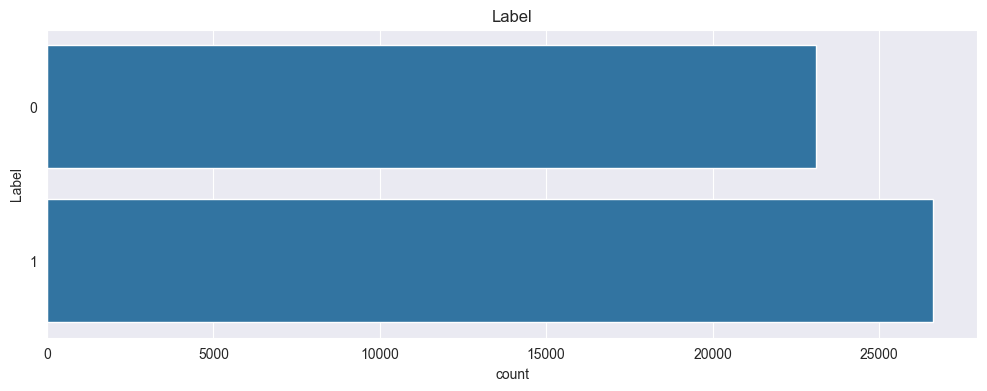

,Label,News,tokenized
0,0,georgia 'downs two russian warplanes' as count...,"[input_ids, token_type_ids, attention_mask]"
1,1,why wont america and nato help us? if they won...,"[input_ids, token_type_ids, attention_mask]"
2,0,remember that adorable 9-year-old who sang at ...,"[input_ids, token_type_ids, attention_mask]"
3,0,u.s. refuses israel weapons to attack iran: r...,"[input_ids, token_type_ids, attention_mask]"
4,1,all the experts admit that we should legalise ...,"[input_ids, token_type_ids, attention_mask]"


In [2]:
import pandas as pd
news_data = pd.read_csv("news.csv")
# Melt the Top1 to Top25 columns into a single column
melted_df = news_data.melt(
    id_vars=["Label"],  # Keep "Label" column as it is
    value_vars=[f"Top{i}" for i in range(1, 26)],  # Columns to unpivot
    var_name="Rank",  # Optional: name for the melted variable column
    value_name="News"  # Name for the melted value column
)

# Drop the "Rank" column as it is no longer needed
melted_df = melted_df.drop(columns=["Rank"])

# Drop rows where "News" is NaN or empty (optional)
melted_df = melted_df.dropna(subset=["News"])

news_data = melted_df

news_data = news_data.replace('b\"|b\'|\\\\|\\\"', '', regex=True)

news_data['News'] = news_data['News'].apply(lambda x:x.lower())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(y=news_data['Label'])
plt.title('Label')
plt.show();
news_data.shape

from transformers import BertTokenizer

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128)

news_data['tokenized'] = news_data['News'].apply(tokenize_function)

news_data.head()

In [3]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(news_data['tokenized'].to_list(), news_data['Label'].to_list(), test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [5]:
def convert_to_dicts(tokenized_texts):
    input_ids = [d['input_ids'] for d in tokenized_texts]
    attention_masks = [d['attention_mask'] for d in tokenized_texts]
    return {'input_ids': input_ids, 'attention_mask': attention_masks}

# Convert to lists of dictionaries
train_encodings = convert_to_dicts(train_texts)
val_encodings = convert_to_dicts(val_texts)
test_encodings = convert_to_dicts(test_texts)

# Create three dataset objects using the SentimentDataset
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [12]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results', # All files generated during training will be stored here
    num_train_epochs=3, # The model will be trained for 3 full epochs unless the step limit (max_steps) is reached first
    per_device_train_batch_size=32, # Training batch size per device (GPU or CPU).
    per_device_eval_batch_size=32, # Evaluation batch size per device (GPU or CPU).
    warmup_steps=10, # Number of warm-up steps during which the learning rate gradually increases to its initial value
    weight_decay=0.01, # Weight decay rate: this technique helps to avoid overfitting, penalizing large weights in the neural network
    logging_dir='./logs', # Directory where training logs will be stored
    #max_steps=10,  # Maximum number of training steps to be performed
    save_steps=10,  # Range of steps after which the model will be saved
    logging_steps=10,  # Range of steps after which log information will be recorded
)

In [ ]:
trainer = Trainer(
    model=model, # The pre-trained model that you want to fine-tune or train
    args=training_args, # The training arguments that specify the configurations for the training process
    train_dataset=train_dataset, # The dataset used for training the model
    eval_dataset=val_dataset # The dataset used for evaluating the model during training
)

# Start training
trainer.train()

In [18]:
results = trainer.evaluate(test_dataset)

print("Evaluation Results:")
print(f"  - Loss: {results['eval_loss']:.4f}")
print(f"  - Runtime: {results['eval_runtime']:.2f} seconds")
print(f"  - Samples per Second: {results['eval_samples_per_second']:.2f}")
print(f"  - Steps per Second: {results['eval_steps_per_second']:.2f}")
print(f"  - Epoch: {results['epoch']:.4f}")

Evaluation Results:
  - Loss: 0.6903
  - Runtime: 10.52 seconds
  - Samples per Second: 708.75
  - Steps per Second: 22.24
  - Epoch: 3.0000


In [19]:
# Save the model and tokenizer in the current folder
model_save_path = "./"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [35]:
def predict_sentiment(text):

    
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs.to('cuda')
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=1).item()
    sentiment = {0: 'DJIA will decrease', 1: 'DJIA will increase'}
    return sentiment[predicted_class]

# Example prediction
example_text = "impeached"
predicted_sentiment = predict_sentiment(example_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: DJIA will increase
